In [2]:
%matplotlib inline

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns

from tsfresh import extract_features
from tsfresh.utilities.dataframe_functions import make_forecasting_frame
from sklearn.ensemble import AdaBoostRegressor
from tsfresh.utilities.dataframe_functions import impute

import warnings
warnings.filterwarnings('ignore')

# Construct the signal

Just for showing how the forecasting works, we invent our own signal here, that we want to forecast later.
It is a mixture of random noise and some sinus graph with a positive and negative slope.

In [4]:
x_up = np.arange(100)*0.1 + np.sin(30*np.pi*np.linspace(0, 1, 100)) + np.random.normal(scale=0.7,size=100)
x_down = np.arange(100, 0, -1)*0.15 + np.sin(30*np.pi*np.linspace(0, 1, 100)) + np.random.normal(scale=0.7,size=100)
x = np.concatenate([x_up, x_down])
x = pd.Series(data=x, index=pd.date_range('1/1/2011', periods=len(x), freq='H'))
x.head()

2011-01-01 00:00:00    0.319690
2011-01-01 01:00:00    0.885400
2011-01-01 02:00:00    0.779785
2011-01-01 03:00:00    1.906754
2011-01-01 04:00:00   -0.183576
Freq: H, dtype: float64

In [17]:
x

2011-01-01 00:00:00    0.319690
2011-01-01 01:00:00    0.885400
2011-01-01 02:00:00    0.779785
2011-01-01 03:00:00    1.906754
2011-01-01 04:00:00   -0.183576
2011-01-01 05:00:00   -0.907088
2011-01-01 06:00:00   -0.471427
2011-01-01 07:00:00    0.167414
2011-01-01 08:00:00    1.506437
2011-01-01 09:00:00    1.563526
2011-01-01 10:00:00    1.256528
2011-01-01 11:00:00   -0.324051
2011-01-01 12:00:00    0.054691
2011-01-01 13:00:00    1.127646
2011-01-01 14:00:00    0.785612
2011-01-01 15:00:00    2.743639
2011-01-01 16:00:00    1.574899
2011-01-01 17:00:00    1.299909
2011-01-01 18:00:00    0.679480
2011-01-01 19:00:00    2.348237
2011-01-01 20:00:00    1.553244
2011-01-01 21:00:00    3.677552
2011-01-01 22:00:00    2.122472
2011-01-01 23:00:00    2.629547
2011-01-02 00:00:00    1.399772
2011-01-02 01:00:00    2.910680
2011-01-02 02:00:00    2.053031
2011-01-02 03:00:00    4.032854
2011-01-02 04:00:00    4.867537
2011-01-02 05:00:00    2.949380
                         ...   
2011-01-

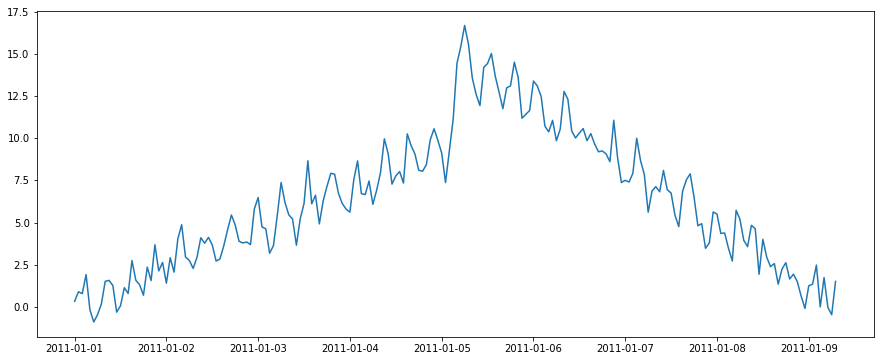

In [5]:
plt.figure(figsize=(15, 6))
plt.plot(x)
plt.show()

So, we have a time series and want to construct a time series model that is able to predict the next data points.

To do that, we have to construct a feature matrix by calculating the features for sub time series (see the forecasting section in the tsfresh documentation).

In [6]:
%load_ext autoreload
%autoreload 2

In [7]:
df = pd.DataFrame(x)
df.reset_index(inplace=True)
df.columns = ["time", "value"]
df["kind"] = "a"
df["id"] = 1

In [8]:
df.head()

,time,value,kind,id
0,2011-01-01 00:00:00,0.319690,a,1
1,2011-01-01 01:00:00,0.885400,a,1
2,2011-01-01 02:00:00,0.779785,a,1
3,2011-01-01 03:00:00,1.906754,a,1
4,2011-01-01 04:00:00,-0.183576,a,1


In [9]:
len(df)

200

In [8]:
from tsfresh.utilities.dataframe_functions import roll_time_series

In [10]:
df_shift, y = make_forecasting_frame(x, kind="price", max_timeshift=10, rolling_direction=1)

`df_shift` is ready to be passed into the feature extraction process in tsfresh 

In [12]:
X = extract_features(df_shift, column_id="id", column_sort="time", column_value="value", impute_function=impute, 
                     show_warnings=False)


Feature Extraction: 100%|██████████| 10/10 [00:11<00:00,  1.12s/it]WARNING:tsfresh.utilities.dataframe_functions:The columns ['value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"intercept"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"rvalue"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"slope"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"stderr"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"intercept"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"rvalue"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"slope"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"stderr"'
 'value__agg_linear_trend__f_agg_"mean"__chunk_len_10__attr_"intercept"'
 'value__agg_linear_trend__f_agg_"mean"__chunk_len_10__attr_"rvalue"'
 'value__agg_linear_trend__f_agg_"mean"__chunk_len_10__attr_"slope"'
 'value__agg_linear_trend__f_agg_"mean"__chunk_len_10__attr_"stderr"'
 'value__agg_linear_trend__f_agg_"me

In [14]:
X.shape

(199, 794)

Here, the first row for `id=2011-01-01 01:00:00` contains features that were just calculate on `2011-01-01 00:00:00`. 
The third row `2011-01-01 03:00:00` contains features that were calculated on `2011-01-01 00:00:00`, `2011-01-01 01:00:00` and `2011-01-01 02:00:00`.

However, because we set `max_timeshift` to 10, the features will only be based on a maximum number of 10 historic data points.

We are now using the features, to train a normal AdaBoostRegressor to predict the next time step. So for every data point, we fit the model on all older data points, then predict the next data point. Then we fit it on all data points again plus that predicted data point and so on.

In [24]:
ada = AdaBoostRegressor()

y_pred = [0] * len(y)
y_pred[0] = y.iloc[0]

for i in range(1, len(y)):
    ada.fit(X.iloc[:i], y[:i])
    y_pred[i] = ada.predict(X.iloc[i, :])
    
y_pred = pd.Series(data=y_pred, index=y.index)

In [25]:
y_pred = pd.Series(data=y_pred, index=y.index)

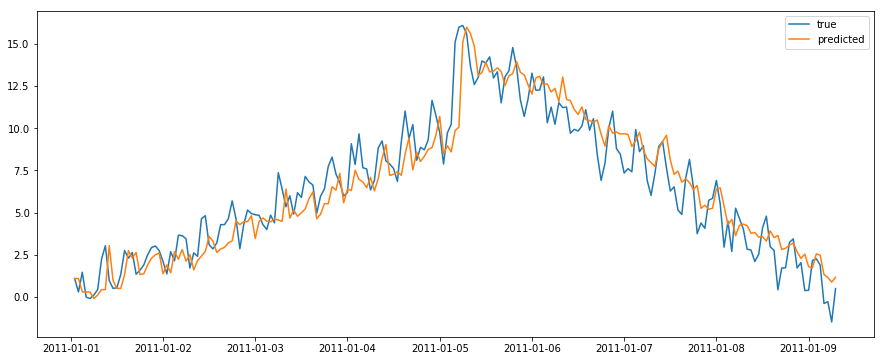

In [26]:
plt.figure(figsize=(15, 6))
plt.plot(y, label="true")
plt.plot(y_pred, label="predicted")
plt.legend()
plt.show()